In [4]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: edgeR

Loading required package: limma



In [44]:
source('milo_cellbender.R')

In [45]:
obj_neuron = qs::qread('_targets/objects/exp_labelled_neuron') %>%
    set_labels_to_class %>%
    set_batch_to_lane %>%
    prep_obj_for_milo_cb_v01

In [46]:
obj_neuron

An object of class Seurat 
29114 features across 104287 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



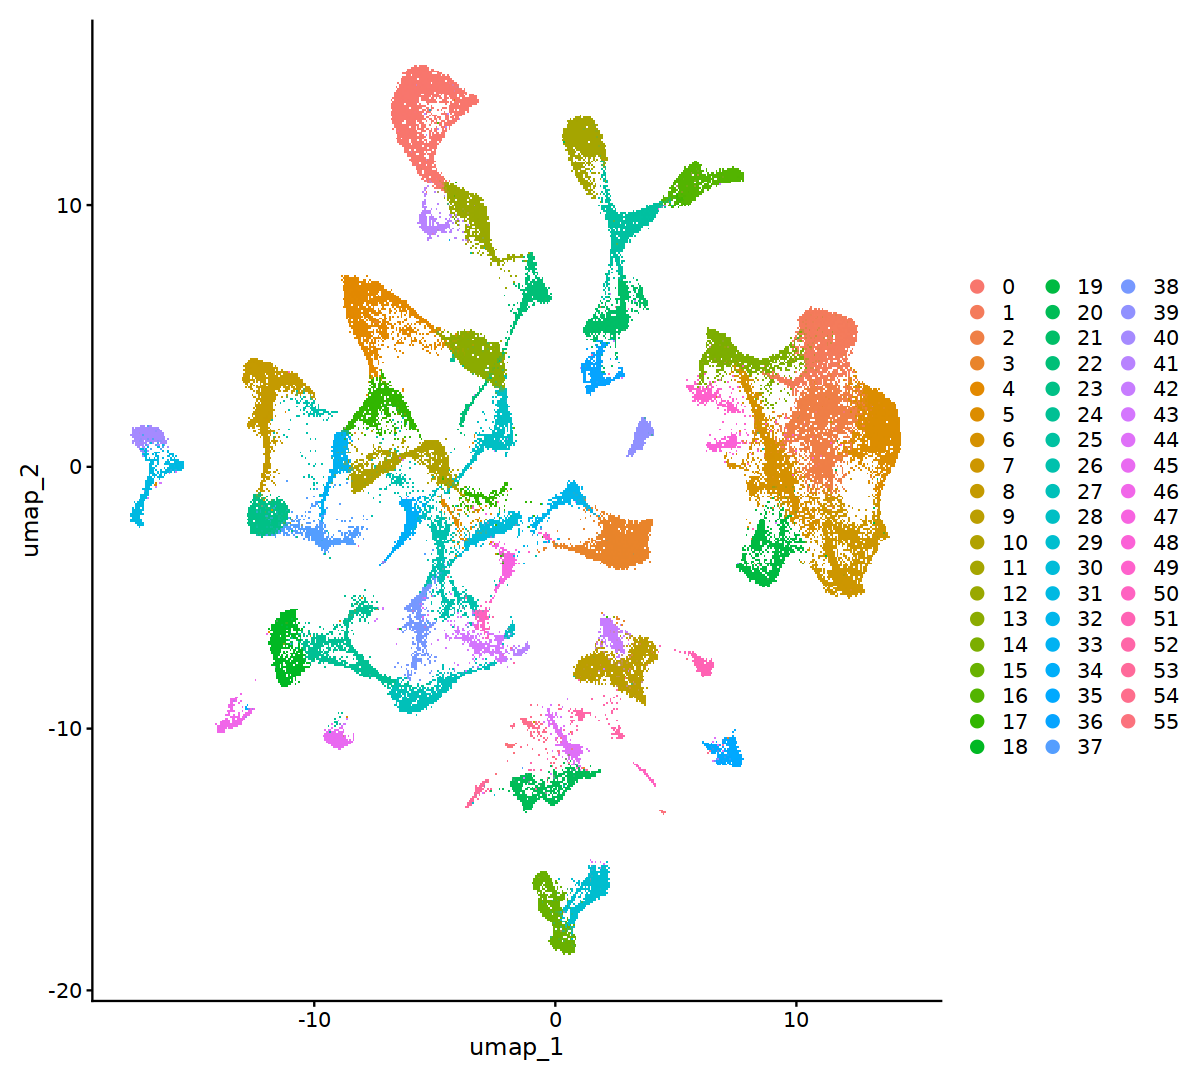

In [47]:
options(repr.plot.width=10, repr.plot.height=9)
DimPlot(obj_neuron)

In [48]:
obj_other = qs::qread('_targets/objects/exp_labelled_other') %>%
    set_labels_to_class %>%
    set_batch_to_lane %>%
    prep_obj_for_milo_cb_v01
obj_other

An object of class Seurat 
25126 features across 32123 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [49]:
obj_milo = qs::qread('_targets/objects/milo_Day5.other')
obj_milo

class: Milo 
dim: 2000 16277 
metadata(0):
assays(1): logcounts
rownames(2000): Opcml Bcas1os2 ... Gm11149 Mirg
rowData names(0):
colnames(16277): SI-TT-A11_AAACGAAAGGTTCTTG SI-TT-A11_AAACGCTAGTGCTAGG
  ... SI-TT-H11_TTTGGTTAGGCACAAC SI-TT-H11_TTTGGTTCACCAACAT
colData names(42): orig.ident nCount_RNA ... group ident
reducedDimNames(2): PCA UMAP
mainExpName: integrated
altExpNames(0):
nhoods dimensions(2): 16277 819
nhoodCounts dimensions(2): 819 18
nhoodDistances dimension(1): 819
graph names(1): graph
nhoodIndex names(1): 819
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 819 819

In [50]:
obj_milo = makeNhoods(obj_milo, prop = 0.5, k = 40, d=30, refined = TRUE)
obj_milo

Checking valid object

Running refined sampling with reduced_dim



class: Milo 
dim: 2000 16277 
metadata(0):
assays(1): logcounts
rownames(2000): Opcml Bcas1os2 ... Gm11149 Mirg
rowData names(0):
colnames(16277): SI-TT-A11_AAACGAAAGGTTCTTG SI-TT-A11_AAACGCTAGTGCTAGG
  ... SI-TT-H11_TTTGGTTAGGCACAAC SI-TT-H11_TTTGGTTCACCAACAT
colData names(42): orig.ident nCount_RNA ... group ident
reducedDimNames(2): PCA UMAP
mainExpName: integrated
altExpNames(0):
nhoods dimensions(2): 16277 1811
nhoodCounts dimensions(2): 819 18
nhoodDistances dimension(1): 819
graph names(1): graph
nhoodIndex names(1): 1811
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 819 819

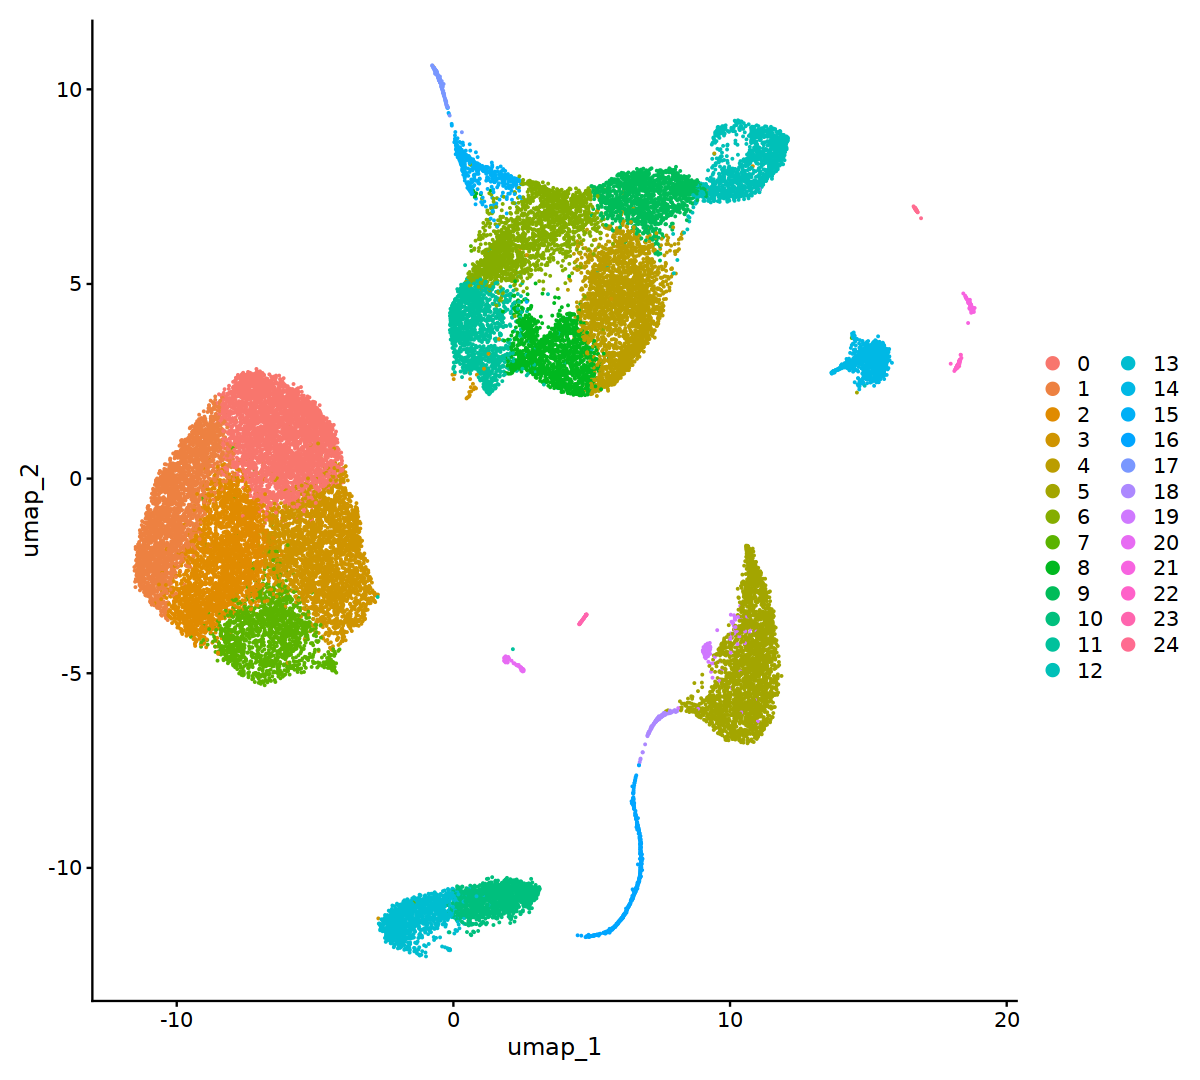

In [51]:
options(repr.plot.width=10, repr.plot.height=9)
DimPlot(obj_other)

In [52]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))
# mutate(class = case_when(labels == 'neuron' ~ 'neuron',
#                          labels == 'other' ~ 'other'))

labels_classes_tib

labels,class
<chr>,<chr>
other,other
neuron,neuron


In [53]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head
umap_coords_neuron %>% dim

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,-0.4342604,6.7461303
2,SI-TT-A11_AAACCCACATACAGCT,-7.3557797,0.3961086
3,SI-TT-A11_AAACCCAGTACGTTCA,-3.4404069,13.9351299
4,SI-TT-A11_AAACCCATCCAAGCAT,7.7133249,-11.4160797
5,SI-TT-A11_AAACCCATCCCATAAG,9.1929654,0.2343295
6,SI-TT-A11_AAACCCATCGTCCTCA,-9.1682301,0.5945974


[1] 104287      3

In [54]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head
umap_coords_other %>% dim

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,1.1562370,5.542229
2,SI-TT-A11_AAACGAAAGCAACAAT,11.2556751,-5.995077
3,SI-TT-A11_AAACGAAAGGTTCTTG,-0.3533742,-10.934463
4,SI-TT-A11_AAACGAACAAGGAGTC,-7.9621904,-3.315451
5,SI-TT-A11_AAACGAACAGCCTTCT,-6.9340403,-2.915615
6,SI-TT-A11_AAACGCTAGTGCTAGG,0.9711418,3.148864


[1] 32123     3

In [55]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [56]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 136410      3

In [7]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_Day5.obob5v5__v__Day5.obobBL6d5') %>%
filter(labels %in% c('neuron', 'other'))
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 3365   18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.037806,8.663731,25.29314,5.842704e-05,0.1487552,529,0.1547179,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,neg_BL6,none,none,neg,SI-TT-E10_TACAACGTCGTTGTGA,103
2,1.953229,8.991314,14.17221,1.163461e-03,0.2138427,142,0.1990098,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-B12_GTGGAAGTCGTCACCT,139
3,1.963383,8.699811,15.41010,7.946932e-04,0.2138427,424,0.1990098,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,neg_BL6,none,none,neg,SI-TT-G10_CTAACCCAGCGTGCCT,103
4,1.431927,9.014329,16.44970,5.834073e-04,0.2138427,569,0.1990098,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-G10_GGGACTCCATGGAGAC,143
5,-1.556248,9.018268,14.80309,9.562507e-04,0.2138427,660,0.1990098,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-H10_CATCGTCCAGATACCT,135
6,-1.260984,9.598950,14.55898,1.301719e-03,0.2138427,678,0.1990098,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,pos_BL6,none,none,pos,SI-TT-E10_TGCTTGCTCCTCAGAA,226


In [58]:
da_results_restored %>% distinct(labels) 

labels
<chr>
neuron
other


In [2]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_Day5.obobBL6d5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC) %>%
filter(labels %in% c('neuron', 'other'))


dim(da_results_bl6)
da_results_bl6 %>% head

ERROR: Error in qs::qread("_targets/objects/combined_da_results_idx_all.obobBL6") %>% : could not find function "%>%"


In [60]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_Day5.obob5v5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)  %>%
filter(labels %in% c('neuron', 'other'))


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 3365   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,2.037806,8.663731,25.29314,5.842704e-05,0.1487552,529,0.1547179,none,neuron,1,103,SI-TT-E10_TACAACGTCGTTGTGA
2,1.953229,8.991314,14.17221,1.163461e-03,0.2138427,142,0.1990098,none,neuron,1,139,SI-TT-B12_GTGGAAGTCGTCACCT
3,1.963383,8.699811,15.41010,7.946932e-04,0.2138427,424,0.1990098,none,neuron,1,103,SI-TT-G10_CTAACCCAGCGTGCCT
4,1.431927,9.014329,16.44970,5.834073e-04,0.2138427,569,0.1990098,none,neuron,1,143,SI-TT-G10_GGGACTCCATGGAGAC
5,-1.556248,9.018268,14.80309,9.562507e-04,0.2138427,660,0.1990098,none,neuron,1,135,SI-TT-H10_CATCGTCCAGATACCT
6,-1.260984,9.598950,14.55898,1.301719e-03,0.2138427,678,0.1990098,none,neuron,1,226,SI-TT-E10_TGCTTGCTCCTCAGAA


In [61]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,2.037806,8.663731,25.29314,5.842704e-05,0.1487552,529,0.1547179,none,neuron,1,⋯,2.5890545,8.663731,33.5050720,1.015309e-05,3.746343e-04,3.139875e-04,none,1,103,SI-TT-E10_TACAACGTCGTTGTGA
2,1.953229,8.991314,14.17221,1.163461e-03,0.2138427,142,0.1990098,none,neuron,1,⋯,0.5101256,8.991314,0.6310845,4.359799e-01,7.893767e-01,7.864636e-01,none,1,139,SI-TT-B12_GTGGAAGTCGTCACCT
3,1.963383,8.699811,15.41010,7.946932e-04,0.2138427,424,0.1990098,none,neuron,1,⋯,3.9270290,8.699811,60.8232296,1.372092e-07,2.054910e-05,1.708973e-05,none,1,103,SI-TT-G10_CTAACCCAGCGTGCCT
4,1.431927,9.014329,16.44970,5.834073e-04,0.2138427,569,0.1990098,none,neuron,1,⋯,0.9611632,9.014329,5.1872416,3.350152e-02,2.843162e-01,2.702013e-01,none,1,143,SI-TT-G10_GGGACTCCATGGAGAC
5,-1.556248,9.018268,14.80309,9.562507e-04,0.2138427,660,0.1990098,none,neuron,1,⋯,-1.0146850,9.018268,4.4480721,4.731289e-02,3.435620e-01,3.289740e-01,none,1,135,SI-TT-H10_CATCGTCCAGATACCT
6,-1.260984,9.598950,14.55898,1.301719e-03,0.2138427,678,0.1990098,none,neuron,1,⋯,-7.5986630,9.598950,97.0547232,1.331849e-08,4.844126e-06,4.123347e-06,neg,1,226,SI-TT-E10_TGCTTGCTCCTCAGAA


In [62]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 3365   39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,2.037806,8.663731,25.29314,5.842704e-05,0.1487552,529,0.1547179,none,neuron,1,⋯,33.5050720,1.015309e-05,3.746343e-04,3.139875e-04,pos,1,103,neuron,-5.2377106,11.718482
2,1.953229,8.991314,14.17221,1.163461e-03,0.2138427,142,0.1990098,none,neuron,1,⋯,0.6310845,4.359799e-01,7.893767e-01,7.864636e-01,none,1,139,neuron,1.6177479,-15.871268
3,1.963383,8.699811,15.41010,7.946932e-04,0.2138427,424,0.1990098,none,neuron,1,⋯,60.8232296,1.372092e-07,2.054910e-05,1.708973e-05,pos,1,103,neuron,-5.1075774,12.082865
4,1.431927,9.014329,16.44970,5.834073e-04,0.2138427,569,0.1990098,none,neuron,1,⋯,5.1872416,3.350152e-02,2.843162e-01,2.702013e-01,none,1,143,neuron,-0.2417057,6.384948
5,-1.556248,9.018268,14.80309,9.562507e-04,0.2138427,660,0.1990098,none,neuron,1,⋯,4.4480721,4.731289e-02,3.435620e-01,3.289740e-01,none,1,135,neuron,3.8510565,-2.222948
6,-1.260984,9.598950,14.55898,1.301719e-03,0.2138427,678,0.1990098,none,neuron,1,⋯,97.0547232,1.331849e-08,4.844126e-06,4.123347e-06,neg,1,226,neuron,-6.4930426,13.457073


In [63]:
da_results %>% group_by(class) %>% summarise(n = n())

class,n
<chr>,<int>
neuron,2546
other,819


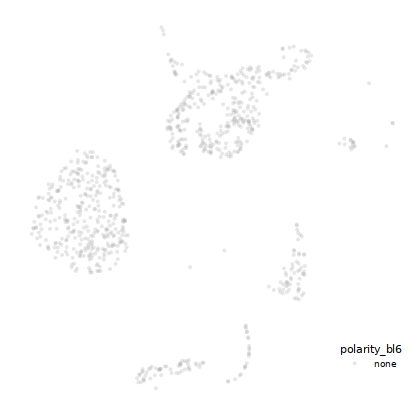

In [64]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

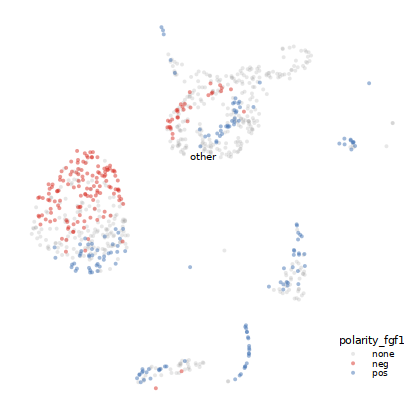

In [65]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

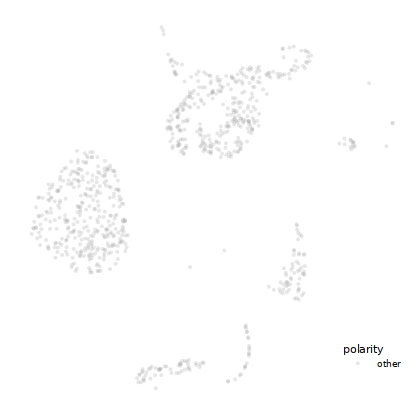

In [66]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [67]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'Day5.obob5v5__v__Day5.obobBL6d5') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
other,819,314,151,163,0.4808917,0,0,0,0,NaN,0.00000000,Day5.obob5v5__v__Day5.obobBL6d5,0.3833944,0.0000000,0.3833944,314
g2,250,98,44,54,0.4489796,71,16,1,15,0.22535211,0.16326531,Day5.obob5v5__v__Day5.obobBL6d5,0.3920000,0.2840000,0.6760000,169
Astrocytes,260,95,43,52,0.4526316,74,14,3,11,0.18918919,0.14736842,Day5.obob5v5__v__Day5.obobBL6d5,0.3653846,0.2846154,0.6500000,169
OPC,77,60,34,26,0.5666667,0,0,0,0,NaN,0.00000000,Day5.obob5v5__v__Day5.obobBL6d5,0.7792208,0.0000000,0.7792208,60
g1,279,60,35,25,0.5833333,0,0,0,0,NaN,0.00000000,Day5.obob5v5__v__Day5.obobBL6d5,0.2150538,0.0000000,0.2150538,60
Htr3b,94,57,27,30,0.4736842,15,1,1,0,0.06666667,0.01754386,Day5.obob5v5__v__Day5.obobBL6d5,0.6063830,0.1595745,0.7659574,72


[1] "other"               "g2"                  "Astrocytes"         
 [4] "OPC"                 "g1"                  "Htr3b"              
 [7] "n1"                  "Tanycytes"           "Trh__Lef1"          
[10] "g3"                  "Agrp"                "Oligodendrocytes"   
[13] "n10"                 "Slc17a6__Trhr"       "Ghrh"               
[16] "Ependymal_cells"     "Pou6f2__Prkcq__Whrn" "Ppp1r17__Tafa4"     
[19] "Sst__Pthlh"          "Tbx19__Pirt"         "Kiss1__Tac2"        
[22] "Pomc__Glipr1"        "n7"                  "Npsr1__Epha3"       
[25] "Irx5__Lmx1a"         "Tmem215__Greb1"      "n2"                 
[28] "Arx__Nr5a2"          "Dlk1"                "Esr1"               
[31] "Fez1"                "Gpr50__Tac2"         "Hdc"                
[34] "Lepr15"              "Lepr67"              "Lepr89"             
[37] "Lpar1_oligo"         "Met__Pappa2"         "Met__Prlh"          
[40] "Microglia"           "Nfib_1"              "Nfib_2"             
[43] "Nfib_3"              "Nfix__Nfib"          "Nfix__Nfib__Hgf"    
[46] "Nfix__Nfib__Lhx6"    "Pomc__Anxa2"         "Pomc__Ttr"          
[49] "Ppp1r17"             "Ppp1r17__Ltbp1"      "Reln__Lef1"         
[52] "Sim1"                "Sst__Nts"            "Sst__Unc13c"        
[55] "Th__Nfib"            "Th__Slc6a3"          "Tmem215__Dach2"     
[58] "Trh__Cxcl12"         "g4"                  "n0"                 
[61] "n3"                  "n4"                  "n5"                 
[64] "n6"                  "n8"                  "n9"                 
[67] "n_drop"              "neuron"

In [68]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,1
other,1
NA,39


In [69]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
neuron,2546,0,NA,NA,NA,163,0,0,0,0,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0,0.064022,0.064022,163,neuron


In [70]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Arx__Nr5a2"       "Dlk1"             "Esr1"             "Fez1"            
 [5] "Gpr50__Tac2"      "Hdc"              "Lepr15"           "Lepr67"          
 [9] "Lepr89"           "Met__Pappa2"      "Met__Prlh"        "Microglia"       
[13] "Nfib_1"           "Nfib_2"           "Nfib_3"           "Nfix__Nfib__Lhx6"
[17] "Ppp1r17__Ltbp1"   "Reln__Lef1"       "Sim1"             "Sst__Nts"        
[21] "Th__Nfib"         "Tmem215__Dach2"   "g4"               "n4"              
[25] "n6"               "n8"               "n_drop"

In [71]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,48,9,6,3,0.6666667,29,8,5,3,0.2758621,0.8888889,Day5.obob5v5__v__Day5.obobBL6d5,0.1875,0.6041667,0.7916667,38


In [72]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
221,other,other,76,pos_FGF1,no,FGF1,pos.FGF1,4.668847e-07,6.849131301,other.FGF1
221,other,other,76,pos_FGF1,no,BL6,none,7.335810e-01,1.375233540,other.BL6
82,other,other,81,pos_FGF1,no,FGF1,pos.FGF1,4.904140e-07,4.819241705,other.FGF1
82,other,other,81,pos_FGF1,no,BL6,none,9.229264e-01,0.506370888,other.BL6
155,other,other,66,pos_FGF1,no,FGF1,pos.FGF1,4.904140e-07,6.654423842,other.FGF1
155,other,other,66,pos_FGF1,no,BL6,none,7.335810e-01,1.447723144,other.BL6
161,other,other,85,pos_FGF1,no,FGF1,pos.FGF1,4.904140e-07,4.633804731,other.FGF1
161,other,other,85,pos_FGF1,no,BL6,none,6.626888e-01,-2.397022498,other.BL6
660,other,other,70,pos_FGF1,no,FGF1,pos.FGF1,4.904140e-07,6.726852867,other.FGF1


In [73]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1   221 other  other      76 pos_FGF1       no       FGF1       pos.FGF1
2   221 other  other      76 pos_FGF1       no       BL6        none    
3    82 other  other      81 pos_FGF1       no       FGF1       pos.FGF1
4    82 other  other      81 pos_FGF1       no       BL6        none    
5   155 other  other      66 pos_FGF1       no       FGF1       pos.FGF1
6   155 other  other      66 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [74]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.FGF1 pos.BL6  neg.BL6 
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [75]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1]  0 11

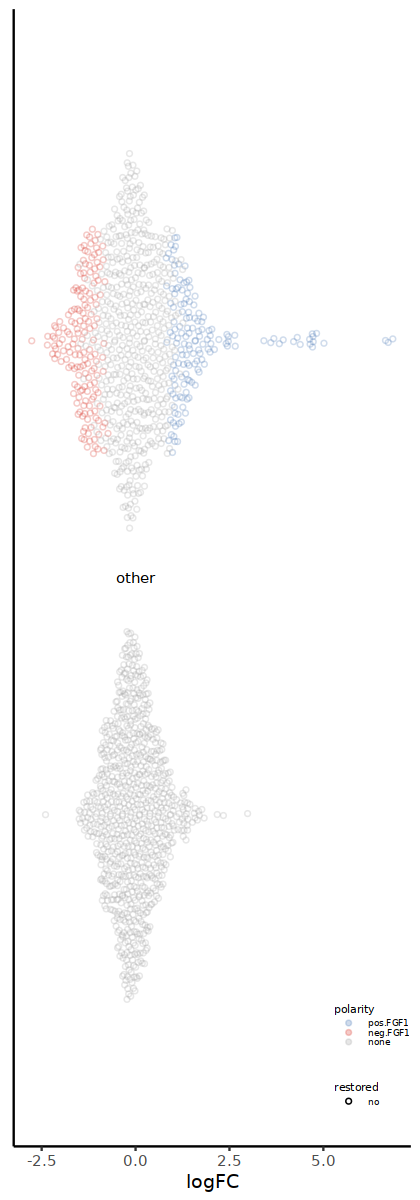

In [76]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

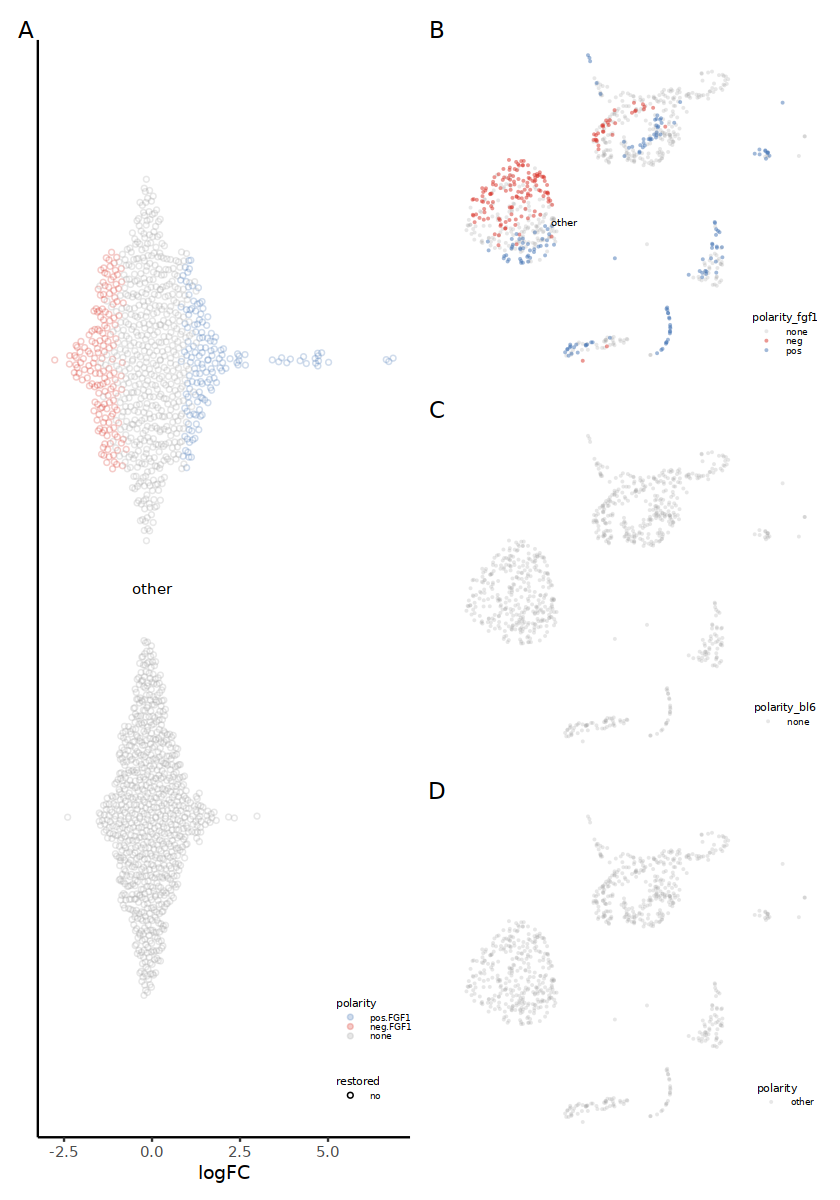

In [77]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_d5_class.pdf', plot = ., width = 7, height=9)
ggp

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 1

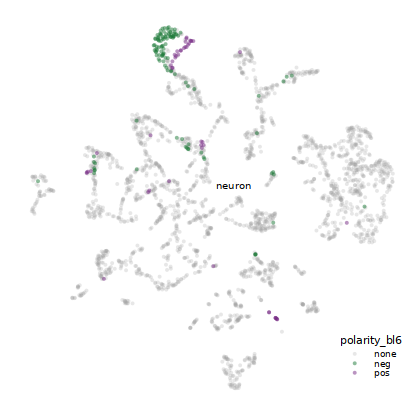

In [78]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 1

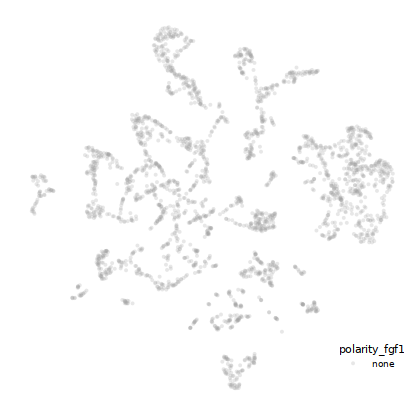

In [79]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

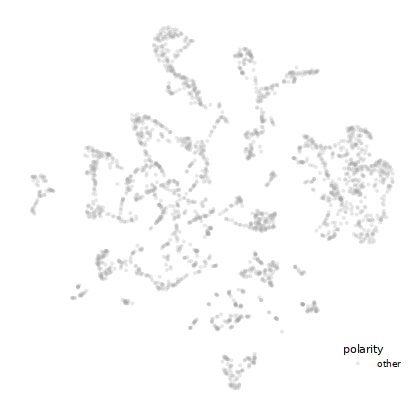

In [80]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

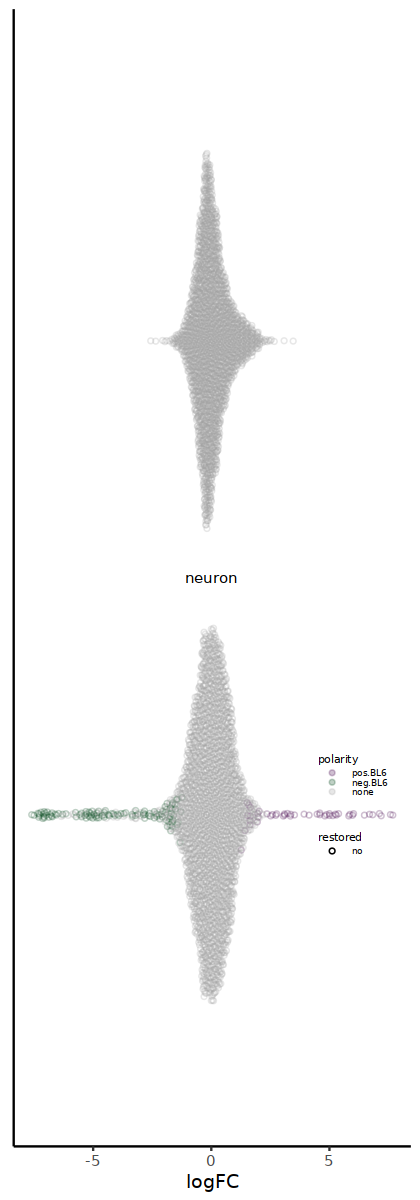

In [81]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

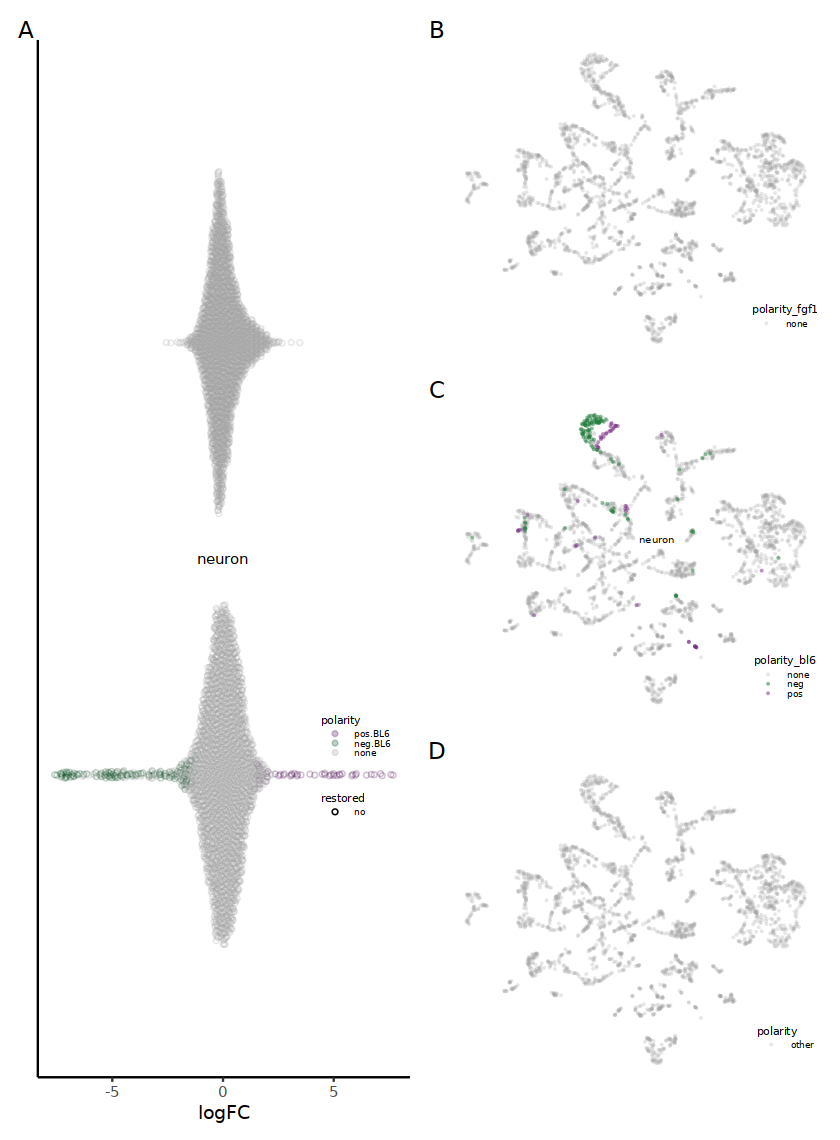

In [82]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_d5_class.pdf', plot = ., width = 7, height=9)
ggp

In [83]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_d5.qs')
da_results %>% qs::qsave('beeswarm_da_results_d5.qs')